# Rincón de Práctica Stata

## Elección Binaria usando Stata

In [1]:
import pandas as pd
import ipystata

</br>
<hr>

### Ejemplo 1 Comparación LPM/Logit/Probit. (nivel usuario)

1. Simular datos $\{y^*_i,x_i\}_{i=1}^N$ para el modelo 
    
    $$y^*_i=3+9*x_i+u_i\hspace{0.6cm}i=1,...,N$$
    
    donde $N=100$, $u\sim\mathbb{N}(0,1)$, $x\sim U[0,1]$ y la variable $y^*$ es una variable latente para la cual solo se observa su contraparte $Y=\mathbb{1}(y^*>P50(y*)))$.
2. Estimar los modelos LPM, Logit y Probit usando comandos de Stata.
3. Presentar los efectos marginales del Logit calculados manualmente (es decir, emplenado $f_i*\beta$). Luego presentar los efectos marginales del Logit y Probit empleando comandos simplificados de Stata.
4. Comparar las probabilidades predichas por los modelos LPM, Logit y Probit.


In [2]:
%%stata
  * 1. Simular datos
    set     seed 123
    set     obs  100
    gen u  = rnormal()
    gen xi = uniform()
    gen ys = 3 + 9*xi + u /* ystar: variable latente */

    qui sum ys
    scalar 	P50  = `r(mean)'
    gen Y   = ys>= P50
    tab Y



Number of observations (_N) was 0, now 100.

          Y |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |         53       53.00       53.00
          1 |         47       47.00      100.00
------------+-----------------------------------
      Total |        100      100.00




Tabla con coeficientes

------------------------------------------------------------
                      (1)             (2)             (3)   
                        Y               Y               Y   
------------------------------------------------------------
main                                                        
xi                  1.528***        10.78***        19.64***
                  (14.84)          (4.76)          (4.26)   

_cons              -0.194***       -4.778***       -8.701***
                  (-3.68)         (-4.63)         (-4.18)   
------------------------------------------------------------
N                     100             100             100   
------------------------------------------------------------
t statistics in parentheses
* p<0.05, ** p<0.01, *** p<0.001

Resultado efecto marginal computo manual f_i*beta

4.8764782

Resultado efecto marginal usando comando mfx o margins

Marginal effects after logit
      y  = Pr(Y) (predict)
      

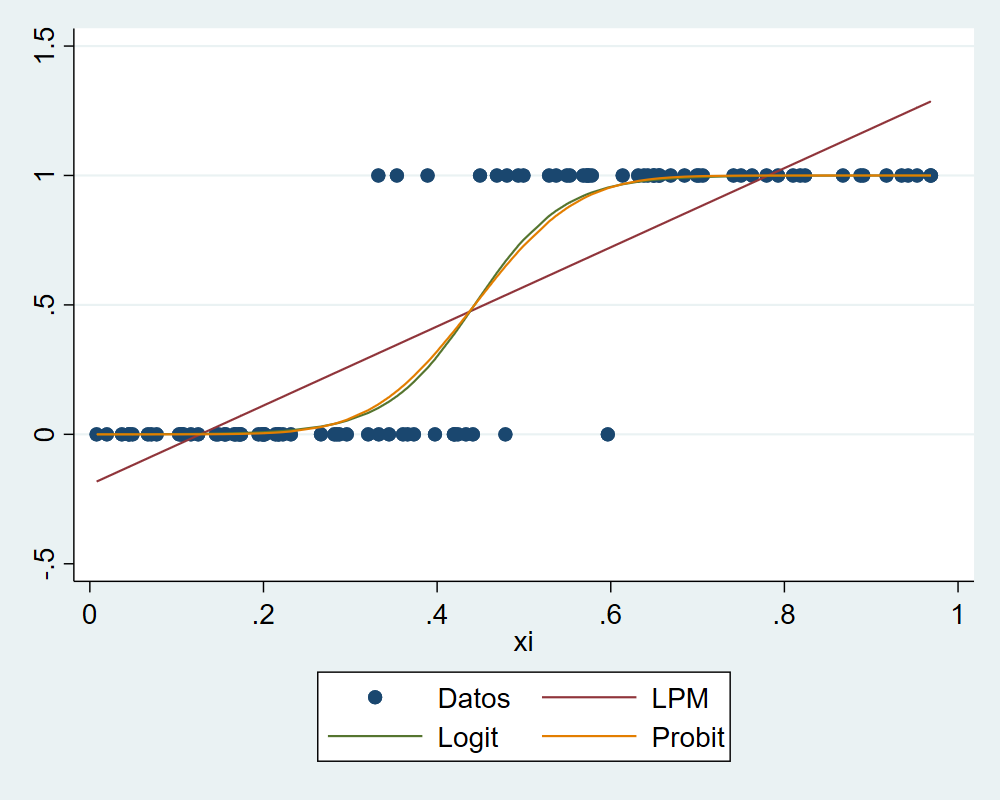

In [3]:
%%stata
  * 2.Comparar LPM, Logit y Probit
    eststo Model_LPM: qui reg Y xi

    eststo Model_Probit: qui probit Y xi

    eststo Model_Logit: qui logit Y xi

    di "Tabla con coeficientes"
    esttab Model_* , mtitles("LPM" "" "Logit") 

  * 3.Efectos marginales
    
    * manualmente (aplicando la teoría):
    qui    mean xi
    scalar xbar = _b[xi]
    qui    logit Y xi
    scalar Xb   = _b[_cons] + _b[xi]*xbar
    
    di "Resultado efecto marginal computo manual f_i*beta"
    display (exp(-Xb) / (1 + exp(-Xb))^2)*_b[x]  /* Efecto Mg = f_i*Beta */
    
    di "Resultado efecto marginal usando comando mfx o margins"
    qui logit Y xi
    mfx

    qui probit Y xi
    mfx

  * 4. Comparación de probabilidades
    qui reg Y xi
    predict prob_ols

    qui logit Y xi 
    predict prob_logit, pr

    qui probit Y xi
    predict prob_probit, pr

    sum prob*

    sort xi
    twoway (scatter Y xi)(line prob_ols xi)(line prob_logit xi) (line prob_probit xi), legend(order(1 "Datos" 2 "LPM" 3 "Logit" 4 "Probit"))



<hr>

### Ejemplo 2 Probit. (nivel intermedio)

1. Simular datos $\{y_i,x_i\}_{i=1}^N$, con $N=100$, en donde la variable $y$ es binaria y $x\sim\mathbb{N}(0,1)$.
2. Escribir un programa en Stata para la función de verosimilitud.
3. Estimar usando el comando `ml` .




In [2]:
%%stata
  * 1. Simular datos 
  gen x = rnormal()
  gen p = normprob(x)
  gen y = rbinomial(1,p)
 
  tab y



Number of observations (_N) was 0, now 100.

          y |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |         50       50.00       50.00
          1 |         50       50.00      100.00
------------+-----------------------------------
      Total |        100      100.00



In [3]:
%%stata
  * 2. Escribir programa para la función log-likelihood
  cap prog drop my_probit
  pro def my_probit
	  args lnf mu
	  qui replace `lnf' = ln(normal( `mu')) if $ML_y1 == 1
	  qui replace `lnf' = ln(normal(-`mu')) if $ML_y1 == 0
  end
  
  * 3. Optimizar la log-likelihood
  ml model lf my_probit (y = x)
  ml max	

  di "Mismo resultado que: probit y x"
  probit y x
   


  1.   args lnf mu
  2.   qui replace `lnf' = ln(normal( `mu')) if $ML_y1 == 1
  3.   qui replace `lnf' = ln(normal(-`mu')) if $ML_y1 == 0
  4.   end

initial:       log likelihood = -69.314718
alternative:   log likelihood = -77.242909
rescale:       log likelihood = -69.314718
Iteration 0:   log likelihood = -69.314718  
Iteration 1:   log likelihood = -34.718464  
Iteration 2:   log likelihood = -34.435641  
Iteration 3:   log likelihood =  -34.43549  
Iteration 4:   log likelihood =  -34.43549  

                                                        Number of obs =    100
                                                        Wald chi2(1)  =  34.43
Log likelihood = -34.43549                              Prob > chi2   = 0.0000

------------------------------------------------------------------------------
           y | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
           x |   1